# Import de bibliotecas e carregamento do dataset

In [24]:
#import das biblitecas necessarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample

In [25]:
# Carregar os dados
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Exploração e Visualização dos Dados

Nesta etapa inicial, realizamos a análise exploratória dos dados (EDA - Exploratory Data Analysis), crucial para entender padrões, identificar problemas de qualidade, relações entre variáveis e guiar as próximas etapas do pipeline de machine learning. O EDA facilita o desenvolvimento de hipóteses, além de embasar decisões técnicas sobre limpeza, seleção de variáveis e estratégias de modelagem.

## Estrutura Básica dos Dados

Antes de mais nada, é essencial compreender a dimensão, a estrutura e os primeiros registros do dataset. Isso facilita a identificação de inconsistências e orienta as primeiras decisões de limpeza e tratamento.

In [23]:
print("Shape dos dados de treino:", train.shape)
train.head()

Shape dos dados de treino: (646, 66)


,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,category_real_estate,category_search,category_security,category_semiconductor,category_social,category_software,category_sports,category_transportation,category_travel,category_web
0,719,3.376474,3.093213,2.253927,2.678128,-0.534224,0.478040,-0.112416,0.813352,1,...,False,False,False,False,False,False,False,False,False,False
1,429,0.618134,-0.082558,-0.175023,-0.091971,1.765599,-0.996012,0.068593,-1.432057,0,...,False,False,False,False,False,False,False,False,False,False
2,178,-0.663267,-0.598194,-0.502412,-0.892222,-0.398940,-0.258986,-0.107494,0.064883,1,...,False,False,False,False,False,False,False,False,False,False
3,197,0.289463,0.330634,2.504860,1.881297,1.089180,-0.258986,-0.066348,0.064883,0,...,False,False,False,False,False,False,False,False,False,False
4,444,-0.684069,0.631137,1.167859,1.272559,2.847868,1.952091,0.179200,1.561822,1,...,False,False,False,False,False,False,False,False,False,True


**Conclusão**

Compreendi quantos exemplos e variáveis temos, além das primeiras linhas, que ajudam a identificar possíveis colunas irrelevantes ou erros de formatação.

## Análise de Valores Nulos

A verificação da presença de valores nulos em cada coluna é fundamental para garantir integridade dos dados. Dados faltantes podem distorcer as análises e impactar negativamente o desempenho do modelo preditivo.

- Exibir a porcentagem de valores nulos orienta decisões de imputação ou exclusão de variáveis/registros.

In [26]:
nulos = train.isnull().mean().sort_values(ascending=False)
display(nulos[nulos > 0] * 100)

age_first_milestone_year    21.362229
age_last_milestone_year     17.182663
age_first_funding_year       5.417957
age_last_funding_year        1.393189
dtype: float64

**Conclusão**

Identifiquei quais colunas e em qual proporção apresentam valores ausentes, o que orienta o tipo de tratamento necessário para manter a qualidade dos dados.

## Estatísticas Descritivas

Analisar as estatísticas descritivas das variáveis numéricas fornece informações sobre tendências centrais, dispersão e possíveis outliers.

- A análise de média, mediana, desvio padrão e quartis é imprescindível para reconhecer padrões de distribuição e ajustes necessários.

In [27]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,646.0,4.615774e+02,2.648595e+02,1.0,233.250,4.595000e+02,6.925000e+02,9.230000e+02
age_first_funding_year,611.0,2.341718e+00,2.468275e+00,0.0,0.680,1.650000e+00,3.600000e+00,2.190000e+01
age_last_funding_year,637.0,4.037724e+00,2.950923e+00,0.0,1.870,3.610000e+00,5.590000e+00,2.190000e+01
age_first_milestone_year,508.0,3.352657e+00,2.866952e+00,0.0,1.185,2.785000e+00,4.935000e+00,2.468000e+01
age_last_milestone_year,535.0,4.944729e+00,3.213319e+00,0.0,2.540,4.620000e+00,6.880000e+00,2.468000e+01
relationships,646.0,7.948916e+00,7.397602e+00,0.0,3.000,6.000000e+00,1.000000e+01,6.300000e+01
funding_rounds,646.0,2.351393e+00,1.357856e+00,1.0,1.000,2.000000e+00,3.000000e+00,8.000000e+00
funding_total_usd,646.0,2.949633e+07,2.261999e+08,11000.0,3000000.000,1.020000e+07,2.587500e+07,5.700000e+09
milestones,646.0,1.913313e+00,1.337095e+00,0.0,1.000,2.000000e+00,3.000000e+00,6.000000e+00
is_CA,646.0,5.464396e-01,4.982245e-01,0.0,0.000,1.000000e+00,1.000000e+00,1.000000e+00


**Conclusão**

É possível identificar variáveis com assimetria, dispersão elevada ou presença de valores extremos, pontos que demandam atenção antes da modelagem.

## Distribuição das Variáveis Numéricas

Visualizar a distribuição de variáveis numéricas como fundingtotalusd, milestones e relationships é essencial para compreender a variabilidade dos dados e identificar anomalias.

- Histogramas mostram a frequência de valores e a presença de caudas longas ou clusterizações.

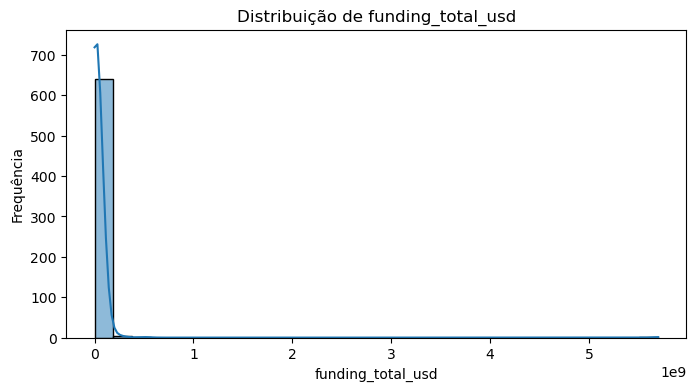

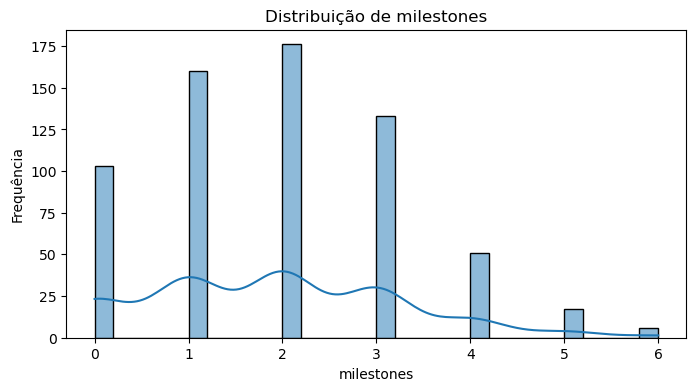

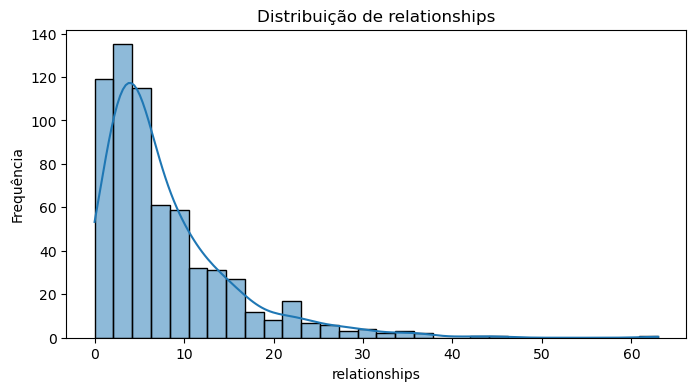

In [29]:
variaveis_numericas = ['funding_total_usd','milestones','relationships']
for col in variaveis_numericas:
    plt.figure(figsize=(8,4))
    sns.histplot(train[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribuição de {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.show()


## Boxplots das Variáveis Numéricas

Os boxplots permitem avaliar a presença de outliers de forma visual. 


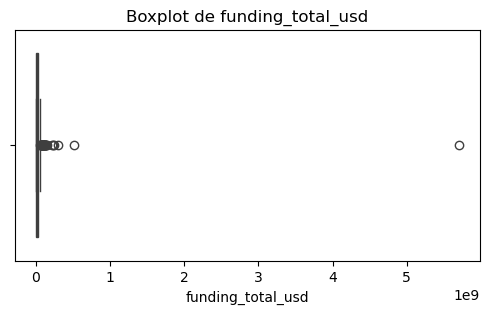

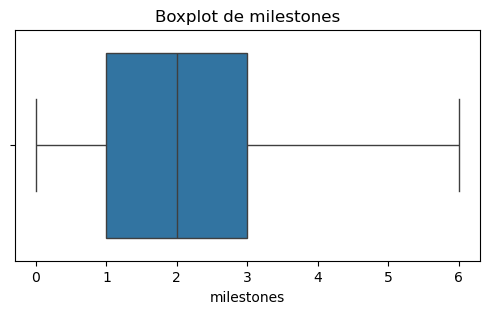

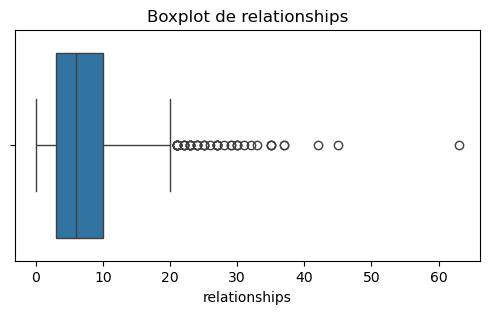

In [30]:
for col in variaveis_numericas:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=train[col])
    plt.title(f'Boxplot de {col}')
    plt.show()


## Distribuição das Variáveis Categóricas

Visualizamos a frequência das principais categorias (por exemplo, category_code) no dataset.

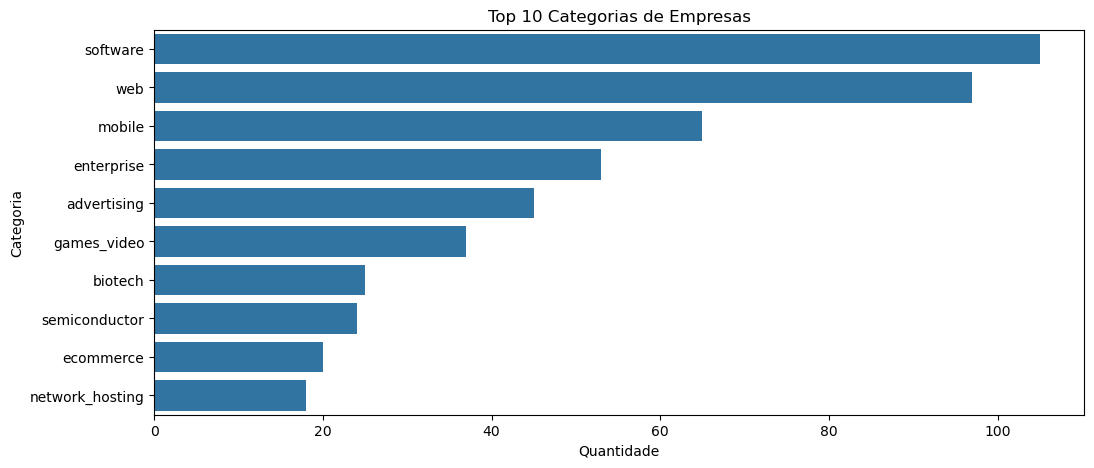

In [31]:
plt.figure(figsize=(12,5))
sns.countplot(y=train['category_code'], order=train['category_code'].value_counts().index[:10])
plt.title("Top 10 Categorias de Empresas")
plt.xlabel("Quantidade")
plt.ylabel("Categoria")
plt.show()


## Correlação entre Variáveis Numéricas

A matriz de correlação evidencia relações lineares entre features numéricas. 


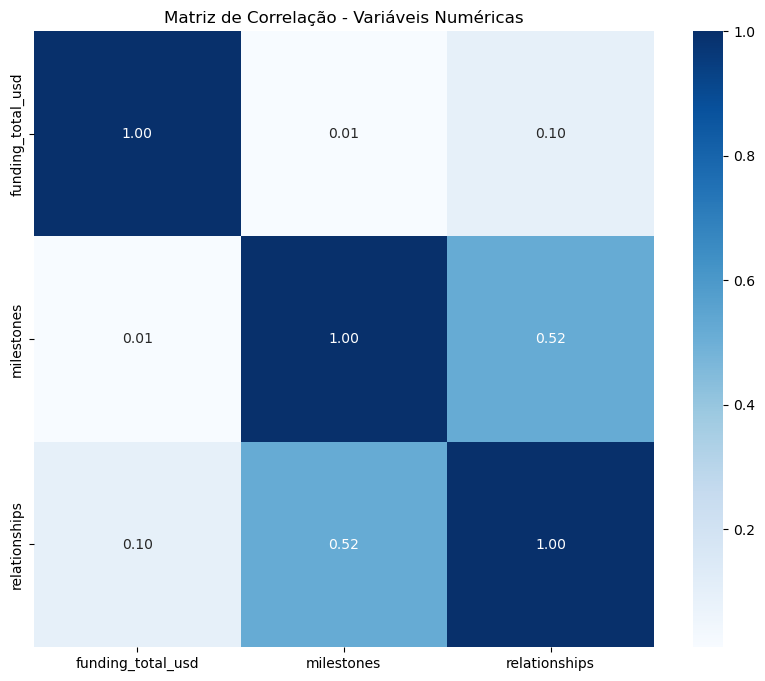

In [32]:
plt.figure(figsize=(10,8))
sns.heatmap(train[variaveis_numericas].corr(), annot=True, cmap='Blues', fmt='.2f')
plt.title("Matriz de Correlação - Variáveis Numéricas")
plt.show()


## Relação entre Features e Target

A análise visual da relação entre as features e o target (variável de sucesso) pode indicar padrões relevantes para a modelagem.

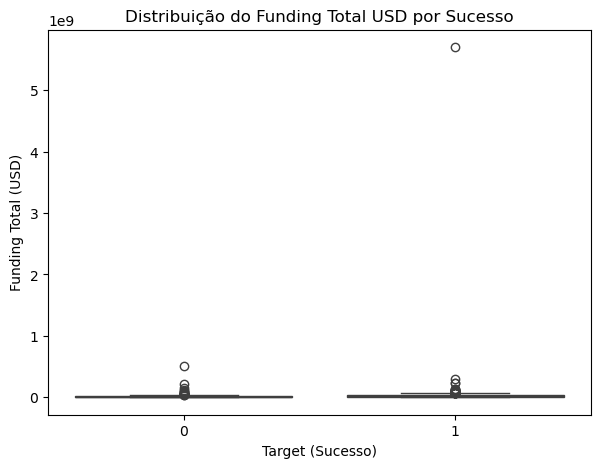

In [37]:
plt.figure(figsize=(7,5))
sns.boxplot(x=train['labels'], y=train['funding_total_usd'])
plt.title("Distribuição do Funding Total USD por Sucesso")
plt.xlabel("Target (Sucesso)")
plt.ylabel("Funding Total (USD)")
plt.show()


In [14]:
# One-hot encoding da coluna 'category_code'
category_dummies_train = pd.get_dummies(train['category_code'], prefix='category')
category_dummies_test = pd.get_dummies(test['category_code'], prefix='category')

# Alinhar colunas entre treino e teste
category_dummies_test = category_dummies_test.reindex(columns=category_dummies_train.columns, fill_value=0)


In [15]:
# Concatenar dummies ao dataset
train = pd.concat([train, category_dummies_train], axis=1)
test = pd.concat([test, category_dummies_test], axis=1)

# Remover a coluna original 'category_code'
train = train.drop(columns=['category_code'])
test = test.drop(columns=['category_code'])

In [16]:
# Colunas com valores faltantes para imputação
cols_with_nan = [
    'age_first_funding_year', 'age_last_funding_year',
    'age_first_milestone_year', 'age_last_milestone_year',
    'funding_total_usd'
]

# Imputação por mediana
imputer = SimpleImputer(strategy='median')
train[cols_with_nan] = imputer.fit_transform(train[cols_with_nan])
test[cols_with_nan] = imputer.transform(test[cols_with_nan])

In [17]:
# Colunas numéricas para padronizar
num_cols = [
    'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year',
    'age_last_milestone_year', 'relationships', 'funding_rounds',
    'funding_total_usd', 'milestones', 'avg_participants'
]

# Padronização
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

In [18]:
# Features selecionadas com base na importância
selected_features = ['relationships', 'funding_total_usd', 'age_last_milestone_year', 'age_last_funding_year', 
                     'age_first_milestone_year', 'age_first_funding_year', 'milestones', 'avg_participants', 
                     'funding_rounds', 'is_otherstate']

In [19]:
# Balancear classes com oversampling
classe_0 = train[train['labels'] == 0]
classe_1 = train[train['labels'] == 1]

if len(classe_0) > len(classe_1):
    classe_1_over = resample(classe_1, replace=True, n_samples=len(classe_0), random_state=42)
    train_balanced = pd.concat([classe_0, classe_1_over])
else:
    classe_0_over = resample(classe_0, replace=True, n_samples=len(classe_1), random_state=42)
    train_balanced = pd.concat([classe_0_over, classe_1])

X_train = train_balanced[selected_features]
y_train = train_balanced['labels']
X_test = test[selected_features]

In [20]:
# Definir modelos
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
ensemble = VotingClassifier(estimators=[('rf', rf_model), ('gb', gb_model)], voting='soft')

In [21]:
# Treinar ensemble com dados balanceados
ensemble.fit(X_train, y_train)

# Prever no conjunto de teste
predictions = ensemble.predict(X_test)

In [22]:
submission = sample_submission.copy()
submission['labels'] = predictions
submission.to_csv('submission.csv', index=False)

print('Arquivo criado: submission.csv')

Arquivo criado: submission.csv
